# Descriptive Analytics of the 2024 Formula 1 season 🏎️

## Introduction 📌

Formula 1 is a sport driven by **precision, data, and strategy**. This project aims to break down the **2024 Formula 1 season** using **data-driven insights** to answer one fundamental question:  
**"What happened during the season?"**  

Using the **FastF1** library, we analyze:  
- **Race & sprint locations** 🗺️  
- **Driver & team performances** 🏆  
- **Fastest laps and telemetry data** ⏱️
- **Drivers consistency and performance** 🏎️
- **DNFs and their causes** ❌  
- **Weather impact on race outcomes** 🌦️  

Each section will present **clear visualizations and key insights** to uncover trends from the season.

## Data Collection & Tools 🛠️

This project is powered by **FastF1**, an open-source Python library that provides **official Formula 1 data**.  
It allows us to retrieve **race results, telemetry data, weather conditions, and more** directly from F1’s timing system.  

### **Why FastF1?**
✅ Provides detailed session data (laps, pit stops, speed, tire usage).  
✅ Includes telemetry data to analyze driver performance.  
✅ Allows correlation between **race events, weather, and results**.  

### **Other Tools Used**
📊 **Pandas** – Data manipulation & analysis.  
🎨 **Matplotlib & Seaborn** – Data visualization.  
📍 **Folium** – Interactive maps for race & sprint locations.  
📈 **Plotly** – Interactive charts for performance analysis.  

⚠️ **Note**: The **Ergast API** (a common F1 data source) has been deprecated, which is why this project focuses **entirely on FastF1**.

## Breaking Down the 2024 season

### Data Overview 🔎

Let's start by **importing the necessary libraries** to begin the project.

As I'm using the **FastF1** library for the very first time, I want to see what the data looks like for the 2024 season.

In [1]:
import fastf1 as ff1
from fastf1 import plotting
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.geocoders import Nominatim
import folium

In [2]:
#Enable cache for faster re-runs
file_path = r"C:\Users\safaa\OneDrive\Documents\Formula1"

#Creates a folder for caching data
ff1.Cache.enable_cache(file_path) 

In [3]:
#Get the schedule of the 2024 season
season_events = ff1.get_event_schedule(2024)

In [4]:
#Make the schedule into a dataframe
season_events_df = pd.DataFrame(season_events)

#print(season_events_df.head())

### Race & Sprint Locations 🌍

Formula 1 is a **global sport**, with races held across multiple continents. This map provides a **visual overview** of the 2024 season, highlighting all **24 race locations** and distinguishing which rounds also hosted a **sprint race**.

In [5]:
#Getting the list of locations (countries) for each round and whether there was a sprint or not
from collections import defaultdict
circuits = []

for _, event in season_events.iterrows():
    if event['EventFormat'] != 'testing':
        session = event.get_session('R')
        session.load()

        round_number = event['RoundNumber']
        country = event['Country']
        location = event['Location']
        event_name = event['OfficialEventName']
        date = event['EventDate']
        name = session.name

        circuits.append({
            "RoundNumber": round_number,
            "Country": country,
            "City": location,
            "OfficialEventName": event_name,
            "Date": date,
            "Session": name
        })

        sprint = event.get_session(3) #Sprints happen in Session3
        if sprint.name == 'Sprint':
            round_number = event['RoundNumber']
            country = event['Country']
            location = event['Location']
            event_name = event['OfficialEventName']
            date = event['EventDate']
            name = sprint.name

            circuits.append({
                "RoundNumber": round_number,
                "Country": country,
                "City": location,
                "OfficialEventName": event_name,
                "Date": date,
                "Session": name
            })

circuit_locations = pd.DataFrame(data=circuits)
#print(circuit_locations)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix

In [6]:
#Join the locations that hosted both a race and a sprint
locations = circuit_locations.groupby('RoundNumber', as_index=False).agg({
    'Country': 'first',
    'City': 'first',
    'OfficialEventName': 'first',
    'Date': 'first',
    'Session': ' + '.join
})

#print(locations)

In [7]:
#Getting the coordinates of the locations to use for our map
geolocator = Nominatim(user_agent="f1_project_geocoder")

def get_coordinates(row):
    try:
        location = geolocator.geocode(f"{row['City']}, {row['Country']}")
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([None, None])

    except Exception as e:
        print(f"Error geocoding {row['City']}, {row['Country']} : {e}")
        return pd.Series([None, None])

locations[['Latitude', 'Longitude']] = locations.apply(get_coordinates, axis=1)

#print(locations)

Error geocoding Shanghai, China : HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Shanghai%2C+China&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error geocoding Budapest, Hungary : HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Budapest%2C+Hungary&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error geocoding Las Vegas, United States : HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Las+Vegas%2C+United+States&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


In [8]:
#Manually adding the coordinates for locations where geocoding failed
failed_geocoding = locations[locations['Latitude'].isnull() | locations['Longitude'].isnull()]

manual_coordinates = {
    #'Melbourne': (-37.8136, 144.9631),
    'Shanghai': (31.2243, 121.4691),
    'Budapest': (47.4979, 19.0402),
    'Las Vegas': (36.1699, -115.1398)
    #'Mexico City': (19.4326, 99.1332)
    #'Yas Island': (24.4670, 54.6030)
}

for i, row in failed_geocoding.iterrows():
    city = row['City']
    if city in manual_coordinates:
        locations.at[i, 'Latitude'] = manual_coordinates[city][0]
        locations.at[i, 'Longitude'] = manual_coordinates[city][1]

#print(locations)

In [9]:
#Plotting the map
from IPython.display import HTML, display

gdf = gpd.GeoDataFrame(
    locations,
    geometry = gpd.points_from_xy(locations['Latitude'], locations['Longitude']),
    crs = "EPSG:4326"
)

m = folium.Map(location=[20, 0], zoom_start=2)

# Create separate layers for Race and Race + Sprint locations
race_layer = folium.FeatureGroup(name="Race Locations")
race_sprint_layer = folium.FeatureGroup(name="Race + Sprint Locations")

for _, row in locations.iterrows():
    # Set color based on EventType
    color = "red" if row['Session'] == "Race" else "green"

    popup_html = f"""
    <b>Country:</b> {row['Country']}<br>
    <b>City:</b> {row['City']}<br>
    <b>Official Event Name:</b> {row['OfficialEventName']}<br>
    <b>Date:</b> {row['Date']}<br>
    <b>Event Type:</b> {row['Session']}
    """
    
    # Add a CircleMarker
    marker = folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=8,  # Size of the circle
        color="black",  # Border color
        fill=True,  # Enable fill
        fill_color=color,  # Fill color (matches border color)
        fill_opacity=0.7,  # Transparency of the fill
        popup=folium.Popup(popup_html, max_width=300),
        tooltip=f"{row['City']} ({row['Session']})"
    )

    marker.add_to(race_sprint_layer)
    if row['Session'] == "Race":
        marker.add_to(race_layer)


race_layer.add_to(m)
race_sprint_layer.add_to(m)

legend_html = """
<div style="
    position: fixed; 
    bottom: 30px; left: 30px; width: 150px; height: 90px; 
    background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
    padding: 10px;">
    <b>Legend</b><br>
    <i style="background:red; width:10px; height:10px; display:inline-block;"></i> Race<br>
    <i style="background:green; width:10px; height:10px; display:inline-block;"></i> Race + Sprint
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

folium.LayerControl(collapsed=False).add_to(m)

map_html = m._repr_html_()
display(HTML(map_html))

In [ ]:
#Saving the map to an HTML file
m.save("locations_map.html")
print("Map successfully saved as 'locations_map.html'")

#### **Key Insights:**
- **🟥 Red markers** indicate events that only had a **Grand Prix (Race)**.
- **🟩 Green markers** highlight events that hosted **both a Sprint & Grand Prix**.
- By hovering over each location, you can see the **official event name, date, and location details**.
- By using the toggle at the top right, you can **filter out the locations to show**.

This map provides a **geographical perspective** on the F1 calendar, helping us see the **distribution of races** and identify which regions host multiple events, like Europe for example.

### Season Winners 🏆

Throughout the **2024 Formula 1 season**, multiple drivers claimed victories across **Grand Prix races and Sprint events**. This visualization showcases all the **race and sprint winners**, highlighting their **teams, driver numbers, and headshots**.

In [10]:
#Getting the team color to use for future visualizations
def team_color(team_name, race):
    try:
        return ff1.plotting.get_team_color(team_name, session=race)
    except KeyError:
        return #000000

In [11]:
winners = []

for _, event in season_events.iterrows():
    if event['EventFormat'] != 'testing':
        session = event.get_session('R')
        session.load()
        results = session.results
        round_number = event['RoundNumber']
        session_name = session.name
        winner = results.iloc[0]
        driver_nb = winner['DriverNumber']
        driver = winner['BroadcastName']
        team = winner['TeamName']
        image = winner['HeadshotUrl']
        color = team_color(winner['TeamName'], session)
        

        winners.append({
            "RoundNumber": round_number,
            "Session": session_name,
            "DriverNumber": driver_nb,
            "Winner": driver,
            "TeamName": team,
            "Headshot": image,
            "TeamColor": color
        })

        sprint = event.get_session(3)
        if sprint.name == 'Sprint':
            sprint.load()
            sprint_results = sprint.results
            round_number = event['RoundNumber']
            sprint_name = sprint.name
            winner = results.iloc[0]
            driver_nb = winner['DriverNumber']
            driver = winner['BroadcastName']
            team = winner['TeamName']
            image = winner['HeadshotUrl']
            color = team_color(winner['TeamName'], sprint)
            

            winners.append({
                "RoundNumber": round_number,
                "Session": sprint_name,
                "DriverNumber": driver_nb,
                "Winner": driver,
                "TeamName": team,
                "Headshot": image,
                "TeamColor": color
            })

winner_data = pd.DataFrame(data=winners)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
req            INFO 	Using cached data for driver_info
core   

In [ ]:
#print(winner_data.head())

In [12]:
race_wins = winner_data[winner_data['Session'] == 'Race'].groupby(['DriverNumber', 'Winner', 'TeamName', 'Headshot', 'TeamColor']).size().reset_index(name='Race Wins')
sprint_wins = winner_data[winner_data['Session'] == 'Sprint'].groupby(['DriverNumber', 'Winner', 'TeamName', 'Headshot', 'TeamColor']).size().reset_index(name='Sprint Wins')

winners_summary = pd.merge(race_wins, sprint_wins, on=['DriverNumber', 'Winner', 'TeamName', 'Headshot', 'TeamColor'], how='left')
winners_summary['Sprint Wins'] = winners_summary['Sprint Wins'].fillna(0).astype(int)
winners_summary = winners_summary.sort_values(by='Race Wins', ascending=False)

#print(winners_summary)

In [13]:
html_content = """
<!DOCTYPE html>
<html>
<head>
    <title>2024 Winners</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f9f9f9;
            margin: 0;
            padding: 0;
        }
        .container {
            display: flex;
            flex-wrap: wrap;
            justify-content: space-evenly;
            align-content: space-evenly;
            height: 100vh;
            margin: 0;
        }
        .card {
            flex: 1 1 calc(23% - 10px); /* Ensure 4 cards per row */
            max-width: calc(23% - 10px);
            border-radius: 10px;
            overflow: hidden;
            color: white;
            text-align: center;
            box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
            position: relative; /* For the hover effect */
        }
        .card img {
            width: 100%;
            height: 150px;
            object-fit: contain;
        }
        .card h2 {
            margin: 5px 0;
            font-size: 1.2em;
        }
        .card p {
            margin: 5px 0;
            font-size: 0.9em;
        }
        .card p.driver-number {
            font-weight: bold;
            text-align: center;
        }
        .hover-popup {
            position: absolute;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            background-color: rgba(0, 0, 0, 0.8);
            color: white;
            display: flex;
            flex-direction: column;
            justify-content: center;
            align-items: center;
            opacity: 0;
            transition: opacity 0.3s ease;
            text-align: center;
        }
        .card:hover .hover-popup {
            opacity: 1; /* Show popup on hover */
        }
        .hover-popup p {
            margin: 5px 0;
            font-size: 1em;
        }
        .title {
            margin-bottom: 0;
        }
    </style>
</head>
<body>
    <h3 class="title">F1 2024 Race & Sprint Winners</h3>
    <div class="container">
"""

for _, row in winners_summary.iterrows():
    popup_content = f"""
        <div class="hover-popup">
            <p>Race Wins: {row['Race Wins']}</p>
            {"<p>Sprint Wins: " + str(row['Sprint Wins']) + "</p>" if row['Sprint Wins'] > 0 else ""}
        </div>
    """
    
    html_content += f"""
    <div class="card" style="background-color: {row['TeamColor']}">
        <img src="{row['Headshot']}">
        <h2>{row['Winner']}</h2>
        <p class="driver-number">Driver Number: {row['DriverNumber']}</p>
        {popup_content}
    </div>
    """

html_content += """
    </div>
</body>
</html>
"""

display(HTML(html_content))

#### **What This Tells Us:**
- Each card represents a **driver who won at least one race or sprint**.
- The **background color** corresponds to the driver’s **team colors**.
- Hovering over a card reveals the **total number of race and sprint wins** for each driver.

This visualization provides a **quick way to identify dominant drivers** throughout the season and compare **who performed best across different race formats**.

**Note:** The code uses the URL provided by the FastF1 to get the drivers' headshots. As you can see, **Hamilton and Sainz appear without their respective team's suits**. My guess is this is happening because both drivers have changed teams for the 2025 season and the headshots have not been updated yet.

In [ ]:
#Saving to an HTML file
with open("2024_winners.html", "w", encoding="utf-8") as f:
    f.write(html_content)

print("Winners saved successfully as '2024_winners.html'")

### Team Podiums 🏆

Podium finishes are a key measure of **team performance** in Formula 1, showcasing their consistency and ability to compete at the front.

In [14]:
from collections import Counter
import fastf1.plotting

podium_finishes = Counter()
colors = dict()

for index, event in season_events.iterrows():
    if event['EventFormat'] != 'testing':
        race = event.get_session('R')
        race.load()
        results = race.results
        podium = results.loc[results['Position'] <= 3, 'TeamName'].values

        for team in podium:
            podium_finishes[team] += 1

        for team in podium:
            colors[team] = team_color(team, race)

team_podiums = pd.DataFrame(podium_finishes.items(), columns=['TeamName', 'Podiums']).sort_values(by='Podiums', ascending=False)
team_colors = pd.DataFrame(colors.items(), columns=['TeamName', 'TeamColor'])

podiums = pd.merge(team_podiums, team_colors, on=['TeamName'], how='left').sort_values(by='Podiums', ascending= False)

#print(podiums)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix

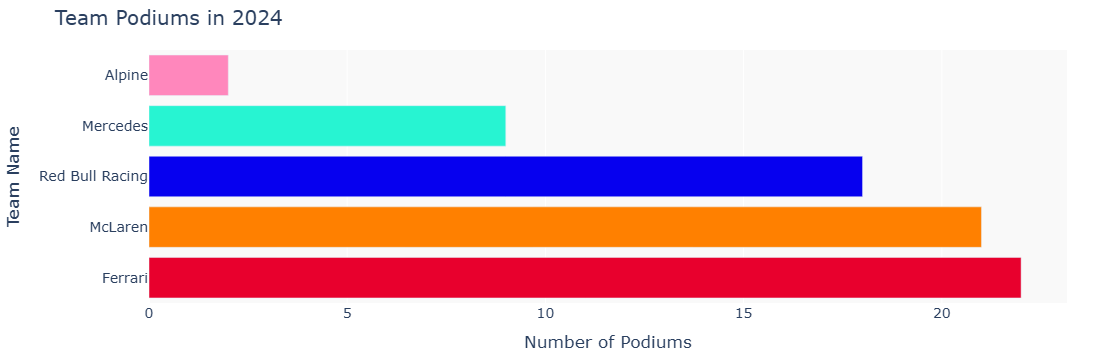

In [15]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x = podiums['Podiums'],
    y = podiums['TeamName'],
    orientation = 'h',
    marker = dict(
        color = podiums['TeamColor']
    )
))

fig.update_layout(
    title = "Team Podiums in 2024",
    xaxis_title = "Number of Podiums",
    yaxis_title = "Team Name",
    plot_bgcolor = "#f9f9f9",
    paper_bgcolor = "#ffffff",
    font = dict(size=14),
    margin = dict(l=100, r=30, t=50, b=30)
)

fig.show()

In [ ]:
#Save as an HTML file
fig.write_html("team_podiums.html")
print("Successfully saved as 'team_podiums.html'")

#### **What This Visualization Shows:**
- Each **bar represents a team**, with the **height indicating the number of podiums** (top 3 finishes) achieved in 2024.
- Bars are **colored according to team colors** for easy identification.
- This allows us to quickly compare which teams were the most competitive across the season.

Podiums reflect not just driver skill but also **car performance, race strategy, and reliability**, making this a **critical metric for evaluating team success**.

**Note:** The FastF1 library **doesn't provide constructors data**, from the research I have done. Knowing the F1 points system, it would be a good practice to add a function to calculate constructors points. This is not part of this project, but an idea for improvement.

### Driver Points Per Event 🔥

Formula 1 is a **season-long battle**, with drivers accumulating points at every race and sprint. This **heatmap** provides a **round-by-round breakdown** of how each driver performed.

In [16]:
driver_points = {}

for _, event in season_events.iterrows():
    if event['EventFormat'] != 'testing':

        session = event.get_session('R')
        session.load()
        for _, row in session.results.iterrows():
            event_name = session.event['Location']
            driver_number = row['DriverNumber']
            driver_name = row['Abbreviation']
            points = row['Points']

            if driver_number not in driver_points:
                driver_points[driver_number] = {
                    'Abbreviation': driver_name,
                    **{f'{event_name}': 0},
                    'Total Points': 0
                }

            driver_points[driver_number][f'{event_name}'] = points
            driver_points[driver_number]['Total Points'] += points

        sprint_session = event.get_session(3)
        if sprint_session.name == 'Sprint':
            sprint_session.load()
            for _, row in sprint_session.results.iterrows():
                event_name = sprint_session.event['Location']
                driver_number = row['DriverNumber']
                driver_name = row['Abbreviation']
                points = row['Points']

                if driver_number not in driver_points:
                    driver_points[driver_number] = {
                        'Abbreviation': driver_name,
                        **{f'{event_name}': 0},
                        'Total Points': 0
                    }
                        
                driver_points[driver_number][f'{event_name}'] = points
                driver_points[driver_number]['Total Points'] += points


driver_points_df = pd.DataFrame(data=driver_points)
#print(driver_points_df.head())

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix

In [17]:
new_driver_points_df = driver_points_df.transpose()
new_driver_points_df = new_driver_points_df.fillna(0)

# Ensure 'Total Points' is the last column
if 'Total Points' in new_driver_points_df.columns:
    new_driver_points_df['Total Points'] = new_driver_points_df.pop('Total Points')

new_driver_points_df.reset_index(inplace=True)
new_driver_points_df.rename(columns={'index': 'DriverNumber'}, inplace=True)
#print(new_driver_points_df)

C:\Users\safaa\AppData\Local\Temp\ipykernel_11476\3861278763.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [18]:
if 'Abbreviation' in new_driver_points_df.columns:
    drivers_standings = new_driver_points_df.groupby('Abbreviation', as_index=False).agg({
        col: 'sum' for col in new_driver_points_df.columns if col not in ['DriverNumber', 'Abbreviation']
    })

    # Sort the grouped data by 'Total Points'
    drivers_standings = drivers_standings.sort_values(by='Total Points', ascending=False)
    print(drivers_standings)
else:
    print("Error: 'Abbreviation' column is missing from the DataFrame.")

   Abbreviation  Sakhir  Jeddah  Melbourne  Suzuka  Shanghai  Miami  Imola  \
22          VER    26.0    25.0        0.0    26.0       8.0    8.0   25.0   
12          NOR     8.0     4.0       15.0    10.0       3.0    0.0   18.0   
10          LEC    12.0    16.0       19.0    12.0       5.0    7.0   15.0   
15          PIA     4.0    12.0       12.0     4.0       2.0    3.0   12.0   
18          SAI    15.0     0.0       25.0    15.0       4.0    4.0   10.0   
17          RUS    10.0     8.0        0.0     6.0       1.0    0.0    7.0   
7           HAM     6.0     2.0        0.0     2.0       7.0    0.0    8.0   
14          PER    18.0    18.0       10.0    18.0       6.0    6.0    4.0   
1           ALO     2.0    10.0        4.0     8.0       0.0    0.0    0.0   
6           GAS     0.0     0.0        0.0     0.0       0.0    0.0    0.0   
8           HUL     0.0     1.0        2.0     0.0       0.0    2.0    0.0   
21          TSU     0.0     0.0        6.0     1.0       0.0    

Successfully saved as 'driver_points_heatmap.png'


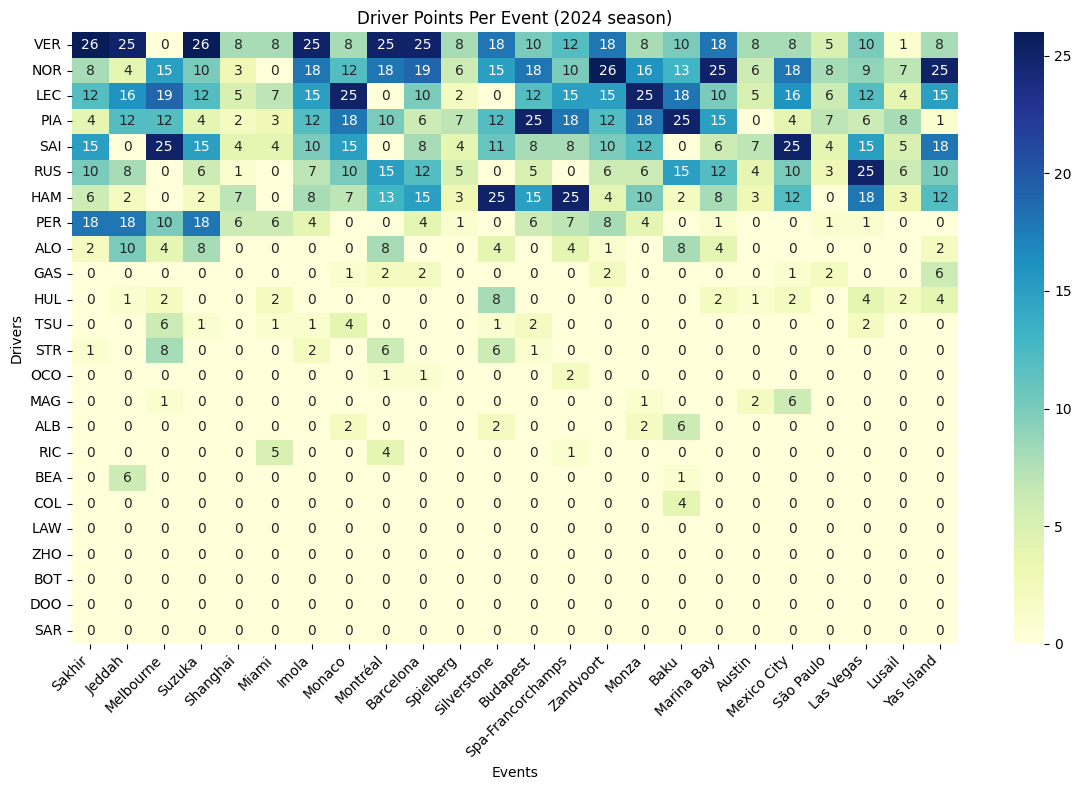

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap (excluding the Abbreviation and Total Points columns)
heatmap_data = drivers_standings.iloc[:, 1:-1]

heatmap_data.index = drivers_standings['Abbreviation']

plt.figure(figsize=(12, 8))
driver_points_heatmap = sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True)

plt.xticks(rotation=45, ha='right')
plt.title("Driver Points Per Event (2024 season)")
plt.xlabel("Events")
plt.ylabel("Drivers")
plt.tight_layout()

#Save as PNG
plt.savefig("driver_points_heatmap.png", dpi=300, bbox_inches="tight")
print("Successfully saved as 'driver_points_heatmap.png'")

plt.show()

#### **Key Insights:**
- The **darker the color**, the more points a driver scored in that event.
- This helps highlight **drivers with consistent high finishes** versus those with **fluctuating performances**.
- It also allows us to **spot trends**, such as mid-season improvements or struggles.

By looking at the heatmap, we can see how drivers' **championship campaigns unfolded**, identifying key moments where they **gained or lost ground**.

### Top 10 Drivers in 2024 🏁

At the end of the season, **only the best drivers** rise to the top of the standings. This visualization highlights the **top 10 drivers** based on their total points.

In [20]:
drivers_info = {
    'Abbreviation': drivers_standings['Abbreviation'],
    'Points': drivers_standings['Total Points']
}

top_drivers = pd.DataFrame(drivers_info)
top_drivers = top_drivers.sort_values(by='Points', ascending=False).head(10)
#print(top_drivers)

In [21]:
drivers_details = {}

for _, event in season_events.iterrows():
    if event['EventFormat'] != 'testing':
        session = event.get_session('R')
        session.load()

        for i, row in session.results.iterrows():
            driver = row['Abbreviation']

            if driver not in drivers_details:
                drivers_details[driver] = {
                    'Team': row['TeamName'],
                    'TeamColor': team_color(row['TeamName'], session)
                }

drivers_details_df = pd.DataFrame(data=drivers_details)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix

In [22]:
drivers_info = drivers_details_df.transpose()
#print(drivers_info)

In [23]:
drivers_info = drivers_info.reset_index()

#print(drivers_info)

In [24]:
drivers_info.rename(columns={'index': 'Abbreviation'}, inplace=True)
#print(drivers_info)

In [25]:
top_10_drivers = pd.merge(
    top_drivers,
    drivers_info,
    on='Abbreviation',
    how='left'
)

#print(top_10_drivers)

In [ ]:
plt.figure(figsize=(10, 8))

bars = plt.barh(
    top_10_drivers['Abbreviation'],
    top_10_drivers['Points'],
    color=top_10_drivers['TeamColor']
)

for bar, points in zip(bars, top_10_drivers['Points']):
    plt.text(
        bar.get_width(),  # Position the text slightly beyond the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically center the text
        f"{points}",  # Text to display (the points)
        va='center',  # Vertical alignment
        fontsize=10,  # Font size
        color='black'  # Text color
    )

plt.xlabel("Total Points")
plt.ylabel("Drivers")
plt.title("Top 10 Drivers (2024 season)")
plt.gca().invert_yaxis()
plt.tight_layout()

#Save as a PNG file
plt.savefig("top_10_drivers.png", dpi=300, bbox_inches="tight")
print("Successfully saved as 'top_10_drivers.png'")

plt.show()

#### **What This Tells Us:**
- **Bars represent total points scored**, with colors matching the **team’s livery**.
- This makes it clear **who dominated the season** and how **close the battle** was between rivals.

This visualization provides a **quick** way to see the **standout drivers of 2024** at a glance.

### Fastest Lap on Track ⚡

Setting the **fastest lap** in a race requires a combination of **raw speed, tire performance, and race conditions**. This visualization maps out **the fastest lap at each circuit**, showing where and when the lap was achieved.

In [26]:
locations = []

for _, event in season_events.iterrows():
    if event['EventFormat'] != 'testing':
        locations.append(event['Location'])

#print(locations)

**Note:** To get the telemetry data, I tried applying the same logic used until now in the notebook but iterating through the season events and using **event.get_session('R')** did not work, hence the need to **specify the location while getting the race session for this section**.

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
events      WARNING 	Correcting user input 'Sakhir' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading

Successfully saved as 'fastest_lap_per_track.png'


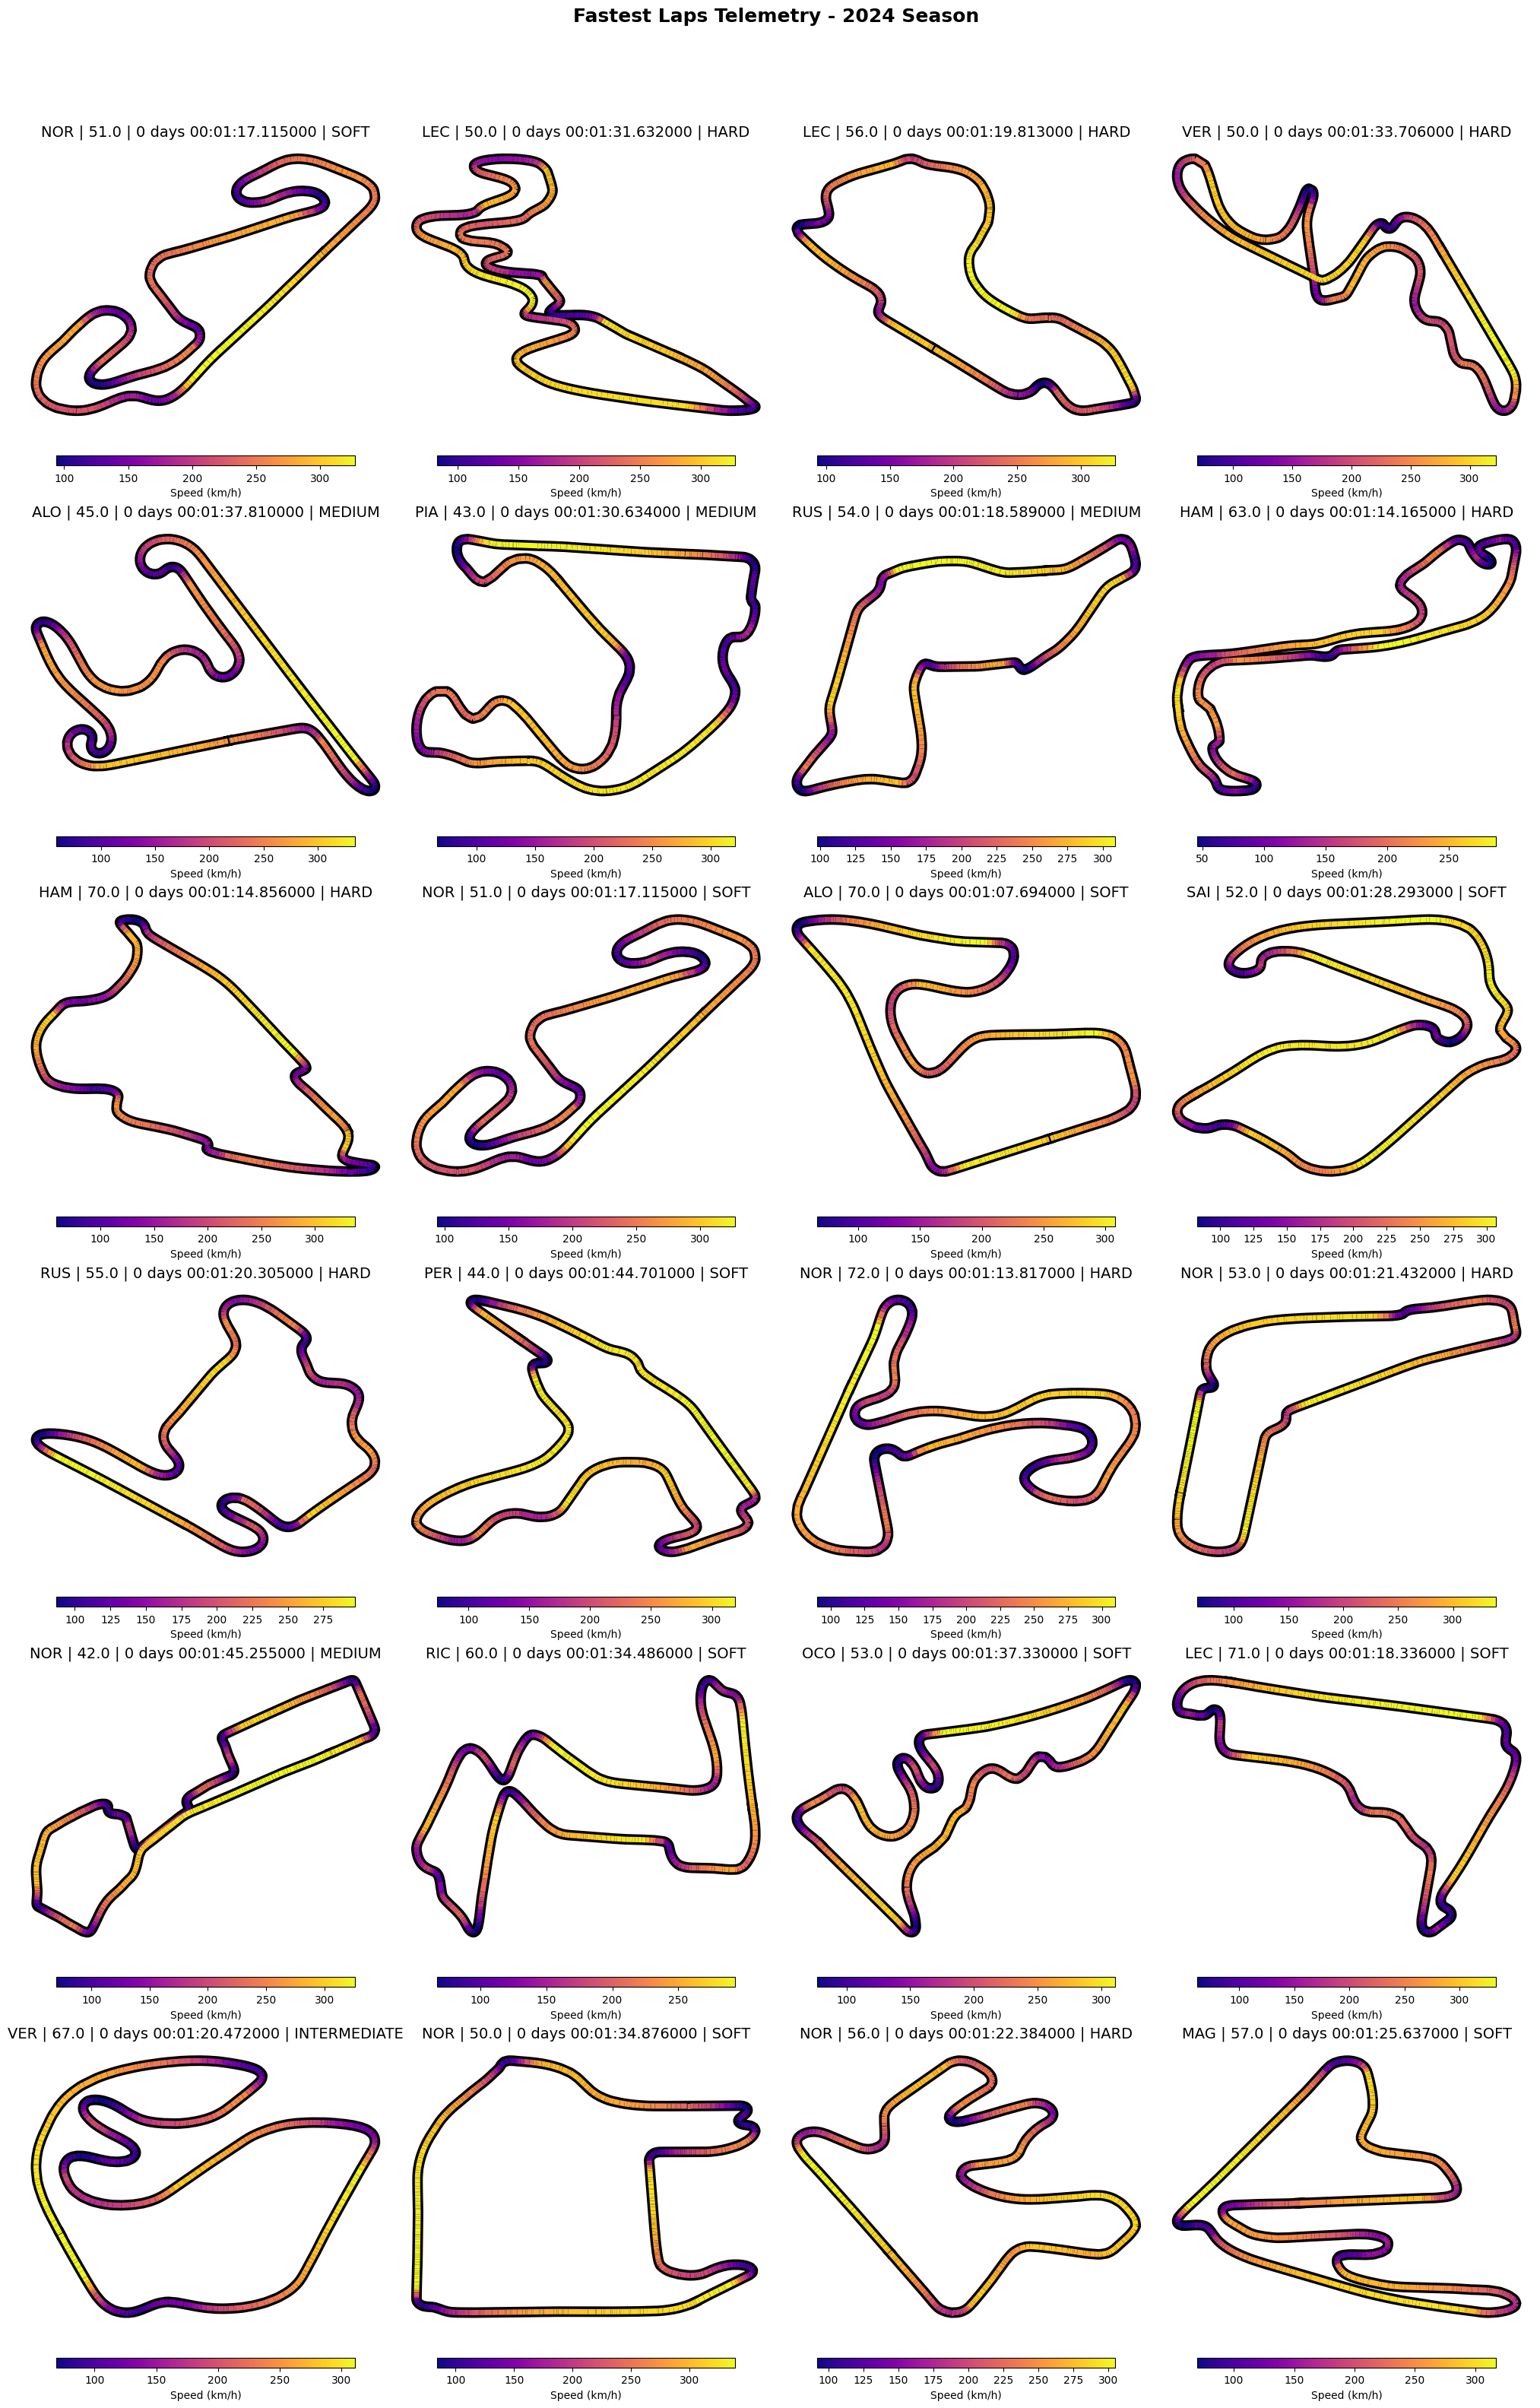

In [27]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np

colormap = mpl.cm.plasma

num_rows = (len(locations) + 4 - 1) // 4

fig, axes = plt.subplots(
    nrows = num_rows,
    ncols = 4,
    figsize = (20, num_rows * 5),
    constrained_layout = True
)

axes = axes.flatten()

fig.suptitle("Fastest Laps Telemetry - 2024 Season", fontsize=18, y=1.05, fontweight='bold')

for i, location in enumerate(locations):
    ax = axes[i]
    race = ff1.get_session(2024, location, 'R')
    race.load()

    lap = race.laps.pick_fastest()

    x = lap.telemetry['X']
    y = lap.telemetry['Y']
    color = lap.telemetry['Speed']

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    ax.axis('off')

    ax.plot(lap.telemetry['X'], lap.telemetry['Y'], color='black', linestyle='-', linewidth=10, zorder=0)

    ax.set_title(f"{lap['Driver']} | {lap['LapNumber']} | {lap['LapTime']} | {lap['Compound']}", fontsize=14, pad=10)
    ax.set_xlabel(f"{location}", fontsize=14)

    norm = plt.Normalize(color.min(), color.max())
    lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle='-', linewidth=5)

    lc.set_array(color)
    line = ax.add_collection(lc)

    cbar = plt.colorbar(
        lc, ax=ax, orientation='horizontal', pad=0.1, aspect=30, shrink=0.8
    )
    cbar.set_label("Speed (km/h)", fontsize=10)

#Save as PNG file
plt.savefig("fastest_lap_per_track.png", dpi=300, bbox_inches="tight")
print("Successfully saved as 'fastest_lap_per_track.png'")

plt.show()

#### **What This Visualization Shows:**
- Each track is plotted based on its **fastest lap telemetry**.
- Colors represent **speed**, providing insight into **where drivers were fastest on the circuit**.
- The **driver’s name, lap time, lap number, and tire compound** are displayed for context.

This visualization helps analyze **where top speeds were achieved**, how **tire choices impacted lap times**, and whether the **fastest laps occurred early or late in the race**.

### Race Performance Consistency 📊

Formula 1 rewards **consistent performance** across the season. This visualization tracks how each driver performed **race after race**, grouped by team.

In [ ]:
consistency_data = []

for _, event in season_events.iterrows():
    if event['EventFormat'] != 'testing':
        race = event.get_session('R')
        race.load()
        for _, row in race.results.iterrows():
            driver = row['Abbreviation']
            race_performance = row['Position']
            quali_performance = row['GridPosition']

            consistency_data.append({
                'Event': event['Location'],
                'Driver': driver,
                'Team': row['TeamName'],
                'Color': team_color(row['TeamName'], race),
                'RacePos': race_performance,
                'QualiPos': quali_performance
            })
            

consistency_data_df = pd.DataFrame(consistency_data)
print(consistency_data_df.head())

In [ ]:
# Get the list of unique teams
teams = consistency_data_df['Team'].unique()
num_teams = len(teams)

# Define number of columns (2 plots per row)
ncols = 2
nrows = (num_teams + ncols - 1) // ncols  # Calculate required rows

# Create larger subplots with 2 plots per row
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5), constrained_layout=True)
axes = axes.flatten()

# Line styles & hue adjustments
line_styles = ["solid", "dashed", "dotted"]
color_shades = [1.0, 0.8, 0.6]  # Shades for 3rd driver (lighter version of team color)

# Loop through each team and plot
for i, team in enumerate(teams):
    ax = axes[i]
    
    team_data = consistency_data_df[consistency_data_df['Team'] == team]
    drivers = team_data['Driver'].unique()

    for j, driver in enumerate(drivers):
        driver_data = team_data[team_data['Driver'] == driver]

        # Adjust color intensity for a third driver
        color = driver_data['Color'].iloc[0]
        if j == 2:  # If a third driver exists, adjust shade
            color = sns.light_palette(color, 3)[2]  # Slightly lighter hue

        # Plot race performance with different line styles
        ax.plot(driver_data['Event'], driver_data['RacePos'], 
                label=driver, color=color, linewidth=2, linestyle=line_styles[j % 3])

    ax.set_title(f"{team}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Event", fontsize=10)
    ax.set_ylabel("Race Position", fontsize=10)
    ax.invert_yaxis()  # P1 at the top
    ax.legend(fontsize=8, loc="upper left")
    ax.tick_params(axis='x', rotation=45)

# Hide any empty subplots if teams < total subplot slots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.savefig("race_consistency.png", dpi=300, bbox_inches="tight")
print("Successfully saved to 'race_consistency.png'")

plt.show()

#### **Key Insights:**
- Each **subplot represents a team**, showing the **race positions of both drivers** over the season.
- **Solid and dashed lines** differentiate drivers while maintaining **team colors**.
- The **y-axis is inverted** (P1 at the top) to reflect finishing positions accurately.

By visualizing **how stable or erratic race results were**, we can identify drivers who **delivered steady results** versus those who experienced **fluctuations in form**.

### Qualifying vs Race Performance 🚥

A strong **qualifying position** doesn’t always translate to a strong **race result**. This visualization compares **where drivers started versus where they finished** in each race.

In [ ]:
# Get unique teams
teams = consistency_data_df['Team'].unique()

# Create a dictionary mapping teams to their drivers
team_drivers = {team: consistency_data_df[consistency_data_df['Team'] == team]['Driver'].unique() for team in teams}

# Calculate number of rows dynamically (1 row per team)
nrows = len(teams)

# Create subplots with dynamic columns per row
fig, axes = plt.subplots(nrows=nrows, ncols=max(len(drivers) for drivers in team_drivers.values()), 
                         figsize=(16, nrows * 5), constrained_layout=True)

# Ensure axes is a 2D array for consistent indexing
if nrows == 1:
    axes = np.expand_dims(axes, axis=0)
if axes.ndim == 1:
    axes = np.expand_dims(axes, axis=1)

# Loop through each team and plot drivers in the same row
for row_idx, (team, drivers) in enumerate(team_drivers.items()):
    for col_idx, driver in enumerate(drivers):
        ax = axes[row_idx, col_idx]

        # Filter data for the driver
        driver_data = consistency_data_df[consistency_data_df['Driver'] == driver]
        color = driver_data['Color'].iloc[0]  # Get the team color

        # Plot race performance (solid line)
        ax.plot(driver_data['Event'], driver_data['RacePos'], 
                label="Race", color=color, linewidth=2, linestyle="solid")

        # Plot qualifying performance (dashed line)
        ax.plot(driver_data['Event'], driver_data['QualiPos'], 
                label="Qualifying", color=color, linewidth=2, linestyle="dashed")

        ax.set_title(f"{driver} ({team})", fontsize=12, fontweight='bold')
        ax.set_xlabel("Event", fontsize=10)
        ax.set_ylabel("Position", fontsize=10)
        ax.invert_yaxis()  # P1 at the top
        ax.legend(fontsize=8, loc="upper left")
        ax.tick_params(axis='x', rotation=45)

    # Hide empty subplots for teams with 2 drivers
    for col_idx in range(len(drivers), axes.shape[1]):
        fig.delaxes(axes[row_idx, col_idx])

# Save figure
plt.savefig("quali_vs_race_performance.png", dpi=300, bbox_inches="tight")
print("Successfully saved as 'quali_vs_race_performance.png'")

plt.show()

#### **What This Shows:**
- Each **subplot focuses on an individual driver**, grouped by team.
- **Dashed lines represent qualifying positions**, while **solid lines represent race positions**.
- **Team colors** ensure easy identification of each driver.

This visualization helps highlight **drivers who consistently gained positions** on race day, those who struggled with **race pace**, and teams with **strong qualifying but weaker race performance**.

### Drivers Most Involved in DNFs 💥

Some drivers are **more prone to DNFs (Did Not Finish) than others**, whether due to **crashes, mechanical failures, or other issues**. This bar chart highlights the **drivers with the most DNFs** in the 2024 season.

In [ ]:
dnf_data = []

for _, event in season_events.iterrows():
    if event['EventFormat'] != 'testing':
        race = event.get_session('R')
        race.load()

        dnfs = race.results[(race.results['Status'] != 'Finished') & ~race.results['Status'].str.startswith('+')]
        
        for _, row in dnfs.iterrows():
            dnf_data.append({
                'Event': event['Location'],
                'Driver': row['Abbreviation'],
                'Team': row['TeamName'],
                'Color': team_color(row['TeamName'], race),
                'DNF': row['Status']
            })

dnf_df = pd.DataFrame(dnf_data)

print(dnf_df)

In [ ]:
driver_dnf_count = dnf_df['Driver'].value_counts()
colors = [dnf_df.loc[dnf_df['Driver'] == driver, 'Color'].iloc[0] for driver in driver_dnf_count.index]

plt.figure(figsize=(10, 6))
plt.barh(driver_dnf_count.index, driver_dnf_count.values, color=colors)
plt.title("Drivers Involved in DNFs (2024)", fontsize=14)
plt.xlabel("Number of DNFs")
plt.ylabel("Drivers")
plt.tight_layout()

#Save as a PNG file
plt.savefig("drivers_dnfs.png", dpi=300, bbox_inches="tight")
print("Successfully saved as 'drivers_dnfs.png'")

plt.show()

#### **Key Takeaways:**
- Each bar represents a **driver**, with the **length indicating the number of DNFs**.
- **Bars are colored based on team colors**, making it easy to identify team trends.
- This helps highlight which drivers were frequently caught in **incidents or reliability issues**.

By analyzing this data, we can see which drivers **struggled with finishing races** and whether their DNFs were more likely due to **driver errors, collisions, or technical failures**.

### Causes of DNFs ⚠️

Understanding **why DNFs occur** is crucial in F1. This pie chart breaks down the **most common reasons** why drivers failed to finish a race in 2024.

In [ ]:
dnf_causes = dnf_df['DNF'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

def autopct_format(pct):
    return f"{pct:.1f}%" if pct > 5 else ""

# Create pie chart
wedges, texts, autotexts = ax.pie(
    dnf_causes,
    labels=None,  # Remove default labels (use legend instead)
    autopct=autopct_format, 
    colors=sns.color_palette("muted"),
    wedgeprops={'edgecolor': 'black', 'linewidth': 1},
    startangle=140
)

# Add a legend to the right
ax.legend(wedges, dnf_causes.index, title="DNF Causes", loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_title("Main causes of DNFs in 2024", fontsize=14)
plt.tight_layout()

#Save as a PNG file
plt.savefig("dnf_causes.png", dpi=300, bbox_inches="tight")
print("Successfully saved as 'dnf_causes.png'")

plt.show()

#### **What This Visualization Shows:**
- Each **slice represents a different cause of DNF**.
- **Larger slices indicate more frequent causes**, while **smaller slices represent rarer failures**.
- A **legend to the side** provides clear labels for each category.

This chart helps highlight whether **mechanical failures, collisions, or other factors** played the biggest role in race retirements.

### DNFs Per Team 🏎️

While some teams enjoy **flawless reliability**, others suffer from **frequent mechanical issues or on-track incidents**. This visualization breaks down **DNFs per team** in 2024.

In [ ]:
dnf_by_team = dnf_df.groupby(['Team', 'DNF']).size().unstack(fill_value=0)

dnf_by_team.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
plt.title("DNFs by cause and team", fontsize=14)
plt.xlabel("Teams")
plt.ylabel("Number of DNFs")
plt.legend(title="Cause", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

#Save as a PNG file
plt.savefig("dnf_cause_team.png", dpi=300, bbox_inches="tight")
print("Successfully saved as 'dnf_cause_team.png'")

plt.show()

#### **What This Reveals:**
- Each **bar represents a team**, showing the **total DNFs across both drivers**.
- This highlights **which teams had the most reliability issues**.
- It also provides insight into **which teams were involved in the most race-ending crashes**.

Teams with **high DNFs** often struggle with **car reliability or driver mistakes**, while teams with **low DNFs** show strong **engineering and consistency**.

**Side Note:** For all Formula 1 fans, going through this section reminded me of the disqualification of Russell at the Belgian Grand Prix for underweight car. As much As I was happy for Hamilton to be promoted to the winner, it was painful to watch the disqualification of Russell unfold after the race.

### Weather Impact on the 2024 Season 🌦️

Weather conditions play a **critical role** in Formula 1, affecting **lap times, tire performance, race incidents, and overall strategy**. This section analyzes how different weather factors—such as **temperature, wind, and rain**—impacted the races in 2024.

In [ ]:
weather_summary = []

for _, event in season_events.iterrows():
    if event['EventFormat'] != 'testing':
        race = event.get_session('R')
        race.load()

        weather_data = race.weather_data

        avg_air_temp = weather_data['AirTemp'].mean()
        avg_track_temp = weather_data['TrackTemp'].mean()
        avg_humidity = weather_data['Humidity'].mean()
        avg_wind_speed = weather_data['WindSpeed'].mean()
        rainfall = weather_data['Rainfall'].any()

        weather_summary.append({
            'Event': event['Location'],
            'AvgAirTemp': avg_air_temp,
            'AvgTrackTemp': avg_track_temp,
            'AvgHumidity': avg_humidity,
            'AvgWindSpeed': avg_wind_speed,
            'Rain': rainfall
        })

weather_df = pd.DataFrame(weather_summary)
print(weather_df.head())

#### **📊 Weather Trends & Race Conditions**
This combined visualization features:
- **Bar chart** showing the **track temperatures for each event**.
- **Scatter plot** overlaying **race-day air temperature**.

By combining these two metrics, we can quickly spot **which races were held in extreme conditions**, potentially affecting car performance and driver strategies.

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for Rain vs Dry Races
ax1.bar(weather_df['Event'], weather_df['Rain'], color=['gray' if not r else 'blue' for r in weather_df['Rain']], alpha=0.7)
ax1.set_ylabel("Rain Occurrence (1 = Yes, 0 = No)", fontsize=12)
ax1.set_xlabel("Event", fontsize=12)
ax1.set_xticklabels(weather_df['Event'], rotation=45, ha='right', fontsize=10)
ax1.set_title("Weather Impact on F1 Races (2024)", fontsize=14)

# Scatter plot for Temperature vs DNF Count
ax2 = ax1.twinx()
ax2.scatter(weather_df['Event'], weather_df['AvgTrackTemp'], color="red", label="Avg Track Temp", marker="o")
ax2.set_ylabel("Avg Track Temp (°C)", fontsize=12)

# Add legend
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), fontsize=10)

# Save figure
plt.savefig("weather_analysis.png", dpi=300, bbox_inches="tight")
print("Successfully saved as 'weather_analysis.png'")

plt.show()

#### **🔥 Heatmaps: Weather vs Performance & DNFs**
To further analyze weather’s impact, we visualize **correlation heatmaps** for:
1. **Weather vs. Average Lap Time** → Did hotter or wetter conditions slow down lap times?  
2. **Weather vs. DNFs** → Were DNFs more common in extreme conditions?  
3. **Weather vs. DNF Causes** → Which types of DNFs (crashes, mechanical failures) were most affected by weather?

These heatmaps provide a **data-driven perspective** on how **weather patterns influenced race outcomes** in the 2024 season.

**1. Weather vs. Average Lap Time**

In [ ]:
lap_weather_corr = []

for _, event in season_events.iterrows():
    if event['EventFormat'] != 'testing':
        race = event.get_session('R')
        race.load()

        avg_lap_time = race.laps['LapTime'].dt.total_seconds().mean()

        weather_data = race.weather_data
        avg_air_temp = weather_data['AirTemp'].mean()
        avg_track_temp = weather_data['TrackTemp'].mean()
        avg_humidity = weather_data['Humidity'].mean()
        avg_wind_speed = weather_data['WindSpeed'].mean()
        rainfall = weather_data['Rainfall'].any()

        lap_weather_corr.append({
                'AvgLapTime': avg_lap_time,
                'AvgAirTemp': avg_air_temp,
                'AvgTrackTemp': avg_track_temp,
                'AvgHumidity': avg_humidity,
                'AvgWindSpeed': avg_wind_speed,
                'Rain': int(rainfall)  # Convert to 0 or 1 for correlation
            })

lap_weather_corr_df = pd.DataFrame(lap_weather_corr)
print(lap_weather_corr_df)

**2. Weather vs. DNFs**

In [ ]:
dnf_weather_corr = []

for _, event in season_events.iterrows():
    if event['EventFormat'] != 'testing':
        race = event.get_session('R')
        race.load()

        dnfs = race.results[(race.results['Status'] != 'Finished') & ~race.results['Status'].str.startswith('+')]
        num_dnfs = len(dnfs)

        weather_data = race.weather_data
        avg_air_temp = weather_data['AirTemp'].mean()
        avg_track_temp = weather_data['TrackTemp'].mean()
        avg_humidity = weather_data['Humidity'].mean()
        avg_wind_speed = weather_data['WindSpeed'].mean()
        rainfall = weather_data['Rainfall'].any()

        dnf_weather_corr.append({
                'NumDNFs': num_dnfs,
                'AvgAirTemp': avg_air_temp,
                'AvgTrackTemp': avg_track_temp,
                'AvgHumidity': avg_humidity,
                'AvgWindSpeed': avg_wind_speed,
                'Rain': int(rainfall)  # Convert to 0 or 1 for correlation
            })

dnf_weather_corr_df = pd.DataFrame(dnf_weather_corr)

**3. Weather vs. DNF causes**

In [ ]:
# Assign numeric values to DNF causes (grouping similar causes)
dnf_mapping = {
    "Collision": 1,
    "Mechanical Failure": 2,
    "Engine": 2,
    "Electronics": 2,
    "Transmission": 2,
    "Fuel System": 2,
    "Brakes": 2,
    "Hydraulics": 2,
    "Suspension": 2,
    "Spin": 3,
    "Crash": 3,
    "Accident": 3,
    "Retired": 4,
    "Disqualified": 4
}

# Apply mapping
dnf_df["DNF Category"] = dnf_df["DNF"].map(dnf_mapping)

# Merge with weather data
dnf_weather_df = pd.merge(dnf_df, weather_df, on="Event")

# Compute correlation matrix
dnf_cause_corr = dnf_weather_df[['DNF Category', 'AvgTrackTemp', 'AvgAirTemp', 'Rain', 'AvgWindSpeed']].corr()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Heatmap 1: Weather vs Avg Lap Time
sns.heatmap(lap_weather_corr_df.corr(), annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Weather vs Avg Lap Time")

# Heatmap 2: Weather vs DNFs
sns.heatmap(dnf_weather_corr_df.corr(), annot=True, cmap="coolwarm", ax=axes[1])
axes[1].set_title("Weather vs DNFs")

# Heatmap 3: Weather vs DNF Causes
sns.heatmap(dnf_cause_corr, annot=True, cmap="coolwarm", ax=axes[2])
axes[2].set_title("Weather vs DNF Causes")

plt.tight_layout()

# Save figure
plt.savefig("weather_correlation_heatmaps.png", dpi=300, bbox_inches="tight")

plt.show()

## Conclusion & Future Work 🏁

As a passionate Formula 1 fan who followed the **2024 season closely**, working on this project was a **fascinating experience**. Revisiting the season through **a data-driven approach** allowed me to uncover trends, compare performances, and analyze key factors that shaped the championship.  
This project combined my **love for F1** with **data analytics**, giving me valuable insights into both the sport and the power of data visualization.

### 🚀 Future Work: Interactive Dashboard  
While this notebook provides a **detailed breakdown of the season**, a potential next step is to **transform this analysis into an interactive dashboard**.  
This would allow users to **explore the data dynamically**, filter specific insights, and enhance **data storytelling through visuals**—an excellent way to refine my **visualization skills**.

Formula 1 is a sport of **precision, strategy, and constant improvement**—and this project reflects that same mindset in the world of data analytics.